Buid a basic chatbot with LangGraph(Graph API)

In [101]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [102]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [103]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [104]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [105]:
# llm=init_chat_model("groq:llama3-8b-8192")

In [106]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F5D9039220>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F5D9039BA0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [107]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [108]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)

graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

graph = graph_builder.compile()

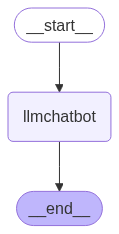

In [109]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [110]:
response = graph.invoke({"messages": "Hi"})

In [111]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [112]:
for event in graph.stream({"messages": "Hi, How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How can I assist you today?


ChatBot with tools

In [113]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)

In [114]:
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers and return the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """ 
    return a * b

In [115]:
tools = [tool, multiply]

In [116]:
llm_with_tools=llm.bind_tools(tools)

In [117]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F5D9039220>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F5D9039BA0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [118]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph=builder.compile()

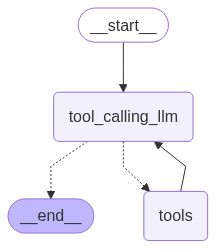

In [119]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [125]:
response=graph.invoke({"messages": "what is the recent ai news and then multiply 2 and 3?"})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is the recent ai news and then multiply 2 and 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5z3d6wkzf)
 Call ID: 5z3d6wkzf
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
  multiply (b0sg4eg39)
 Call ID: b0sg4eg39
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4008912/wormgpt-returns-new-malicious-ai-variants-built-on-grok-and-mixtral-uncovered.html", "title": "WormGPT returns: New malicious AI variants built on Grok and Mixtral uncovered - csoonline.com", "score": 0.70214266, "published_date": "Wed, 18 Jun 2025 12:17:59 GMT", "content": "news ### New npm threats can erase production sys